In [9]:
import os
import gc
import re
import pickle
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter

In [10]:
data = pd.read_csv("https://raw.githubusercontent.com/GonieAhn/Data-Science-online-course-from-gonie/main/Data%20Store/example_data.csv")

In [11]:
data.head()

,censor,event,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,gender,str2,strat,symptom,cd40,cd420,cd496,r,cd80,cd820
0,0,1090,43,66.679,0,1,0,100,0,1,...,1,1,3,0,504,353,660,1,870,782
1,1,794,31,73.030,0,1,0,100,0,1,...,1,1,3,0,244,225,106,1,708,699
2,0,957,41,66.226,0,1,1,100,0,1,...,1,1,3,0,401,366,453,1,889,720
3,1,188,35,78.019,0,1,0,100,0,1,...,1,1,3,0,221,132,-1,0,221,759
4,1,308,40,83.009,0,1,0,100,0,1,...,1,1,3,1,150,90,20,1,1730,1160


In [12]:
Y = data['censor']
X = data.drop(columns=['censor'])

In [13]:
SKFold = StratifiedKFold(n_splits=5, shuffle=True)

In [14]:
train_idx = []
valid_idx = []
data_split = SKFold.split(X, Y)
data_split=next(data_split)
train_idx = data_split[0]
valid_idx = data_split[1]

In [15]:
model = LGBMClassifier(learning_rate=0.06, n_estimators=50, reg_lambda=0.5, 
                      reg_alpha=0.5, max_depth=5, objective='cross_entropy')
model.fit(X.iloc[train_idx], Y.iloc[train_idx])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] [cross_entropy:Init]: (objective) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: (metric) labels passed interval [0, 1] check
[LightGBM] [Info] [cross_entropy:Init]: sum-of-weights = 425.000000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1057
[LightGBM] [Info] Number of data points in the train set: 425, number of used features: 20
[LightGBM] [Info] [cross_entropy:BoostFromScore]: pavg = 0.341176 -> initscore = -0.658056
[LightGBM] [Info] Start training from score -0.658056
[Li

LGBMClassifier(learning_rate=0.06, max_depth=5, n_estimators=50,
               objective='cross_entropy', reg_alpha=0.5, reg_lambda=0.5)

In [16]:
# SHAP Explainer 만들기
explainer = shap.TreeExplainer(model)
# Shap values 계산
shap_values = explainer.shap_values(X.iloc[train_idx])

In [17]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[2, :], X.iloc[train_idx[2], :], link="logit")

In [18]:
# 누적 시각화
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X.iloc[train_idx])

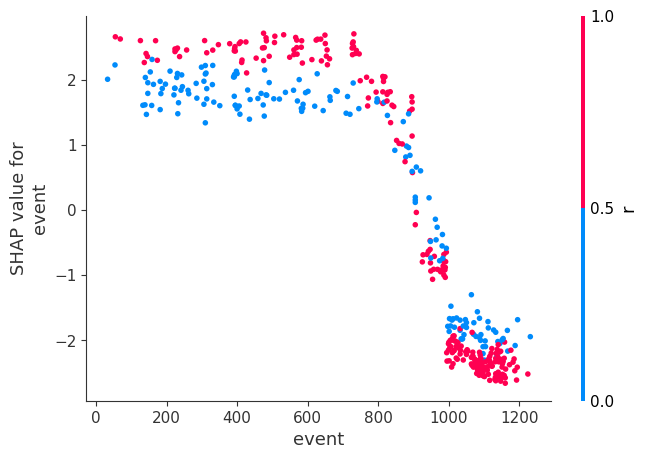

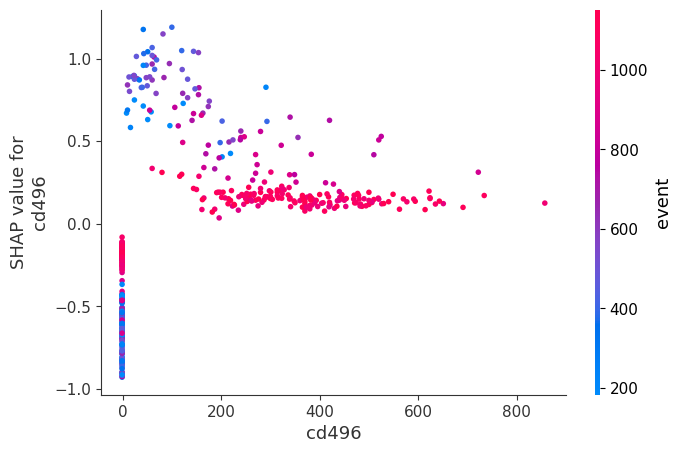

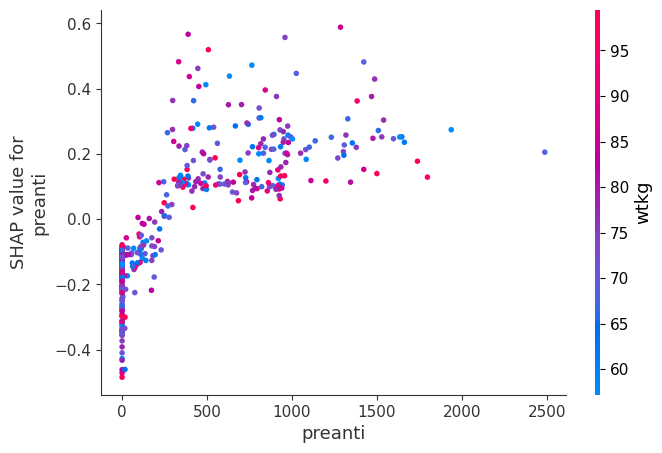

In [19]:
# Shap Value의 절대 값이 큰 순서대로 정렬함
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))
# 영향력 Top 3에 대한 Dependence plot 
for i in range(3):
    shap.dependence_plot(top_inds[i], shap_values, X.iloc[train_idx])

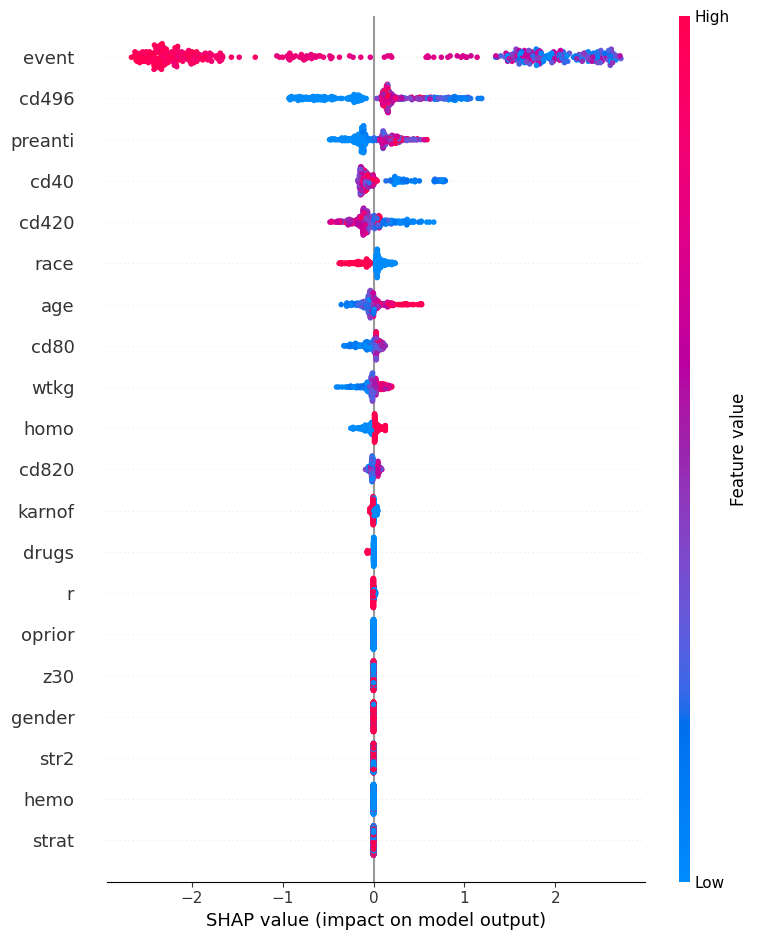

In [20]:
shap.summary_plot(shap_values, X.iloc[train_idx])

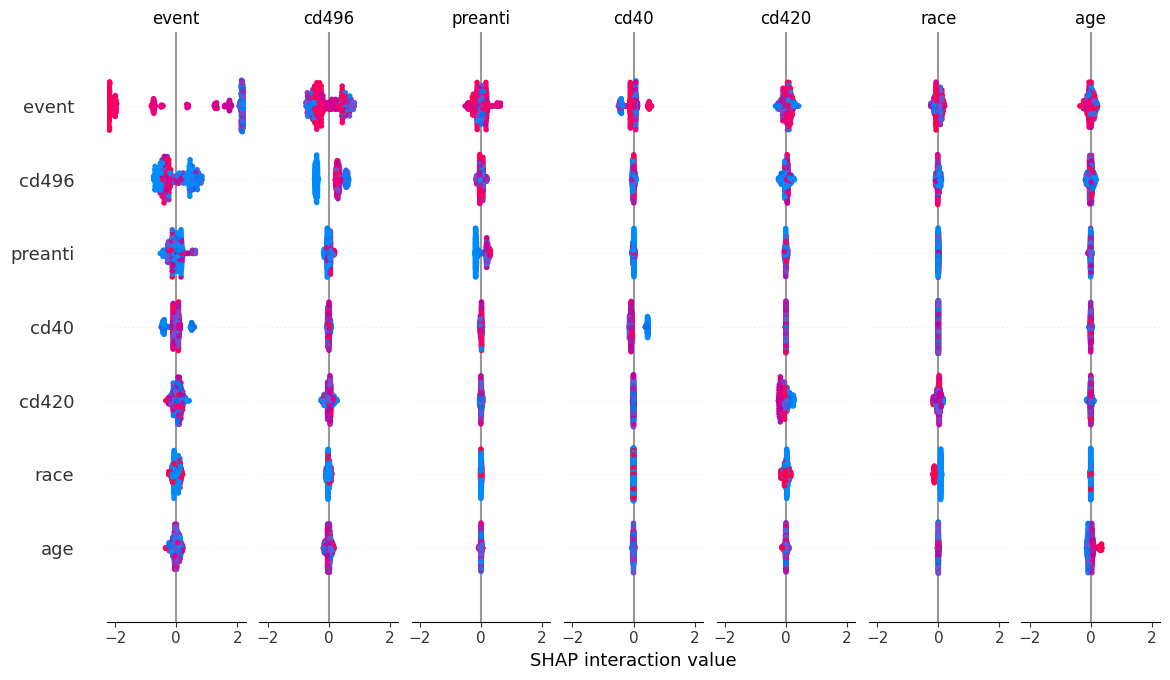

In [21]:
shap_interaction_values = explainer.shap_interaction_values(X.iloc[train_idx])
shap.summary_plot(shap_interaction_values, X.iloc[train_idx])